In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

Using TensorFlow backend.


### 1. 读取数据并可视化地震数据的折线图

[[7.8]
 [5. ]
 [5.4]
 ...
 [5.1]
 [5.1]
 [6.2]]
(1546, 1)


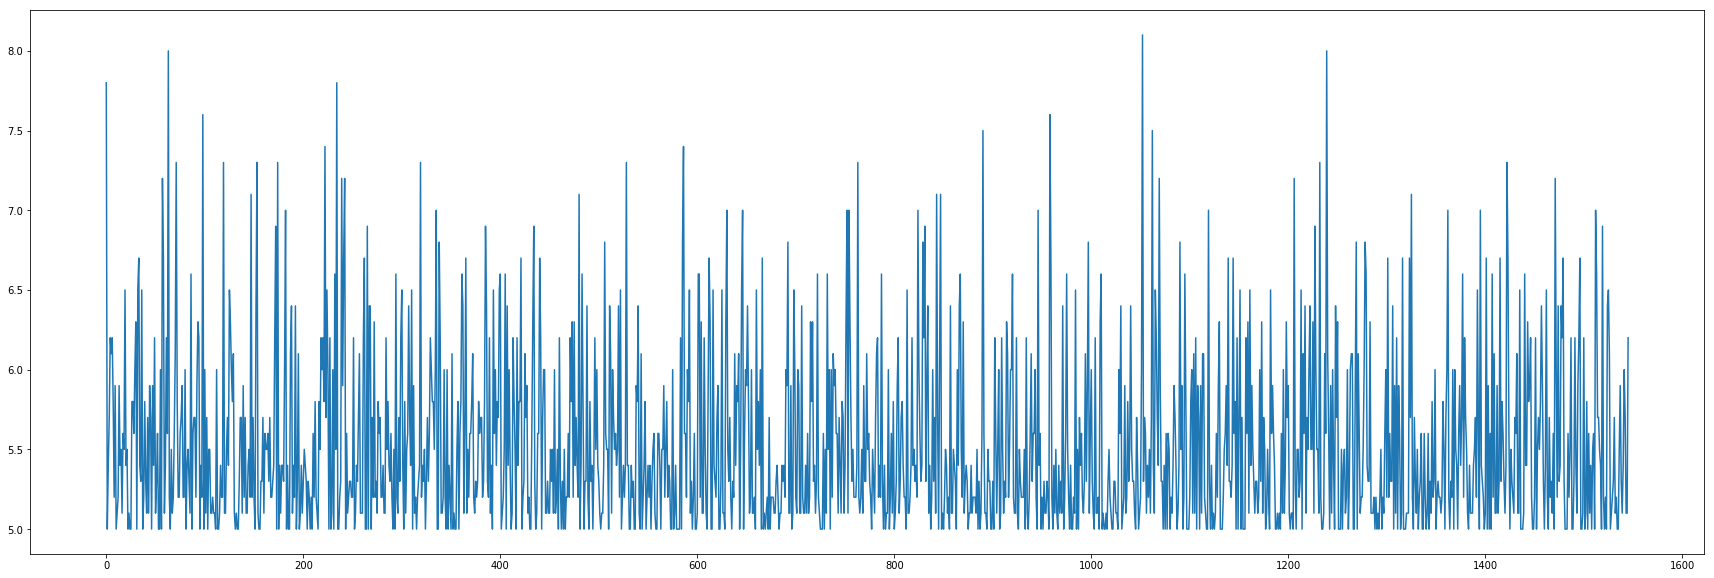

In [18]:
# 载入数据
dataframe = read_csv('./data/eq_date.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
print(dataset)
print(dataset.shape)
plt.figure(figsize=(30,10))
plt.plot(dataset)
plt.show()

### 2. 数据预处理
- 对数据进行归一化、标准化
- 数据转化，采用时间窗方法，以使得时序预测问题可转换为传统的监督学习问题
- 划分 67% 训练集 + 33% 测试集
- 转化为LSTM指定格式 [samples, time steps, features]

In [19]:
# 归一化
scaler = MinMaxScaler(feature_range=(0, 1)) 
# 标准化
# 对数据先拟合fit，找到整体指标，如均值、方差、最大值最小值等，再进行transform转换
dataset = scaler.fit_transform(dataset) 

# 划分 67% 训练集 + 33% 测试集
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [39]:
# 数据转化，按（t，t+1）的顺序
# X 是 t 对应震级 
# Y 是 t+1 对应震级
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)


In [68]:
# 数据转化，此时shape为（样本个数, 输入的维度）
look_back = 70
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [69]:
# 投入到 LSTM 的 X 需要有这样的结构： [samples, time steps, features]，所以做一下变换 ->（样本个数，1，输入的维度）
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [70]:
trainX.shape

(964, 1, 70)

In [71]:
trainY.shape

(964,)

### 3. 构建LSTM模型
输入层有 1 个input，隐藏层有 5 个神经元，输出层就是预测一个值，激活函数用 sigmoid，迭代 50 次，batch size 为 50

In [72]:
# 构建模型并训练
model = Sequential()
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=50, verbose=2)

Epoch 1/50
0s - loss: 0.0538
Epoch 2/50
0s - loss: 0.0362
Epoch 3/50
0s - loss: 0.0327
Epoch 4/50
0s - loss: 0.0322
Epoch 5/50
0s - loss: 0.0320
Epoch 6/50
0s - loss: 0.0318
Epoch 7/50
0s - loss: 0.0317
Epoch 8/50
0s - loss: 0.0316
Epoch 9/50
0s - loss: 0.0315
Epoch 10/50
0s - loss: 0.0314
Epoch 11/50
0s - loss: 0.0314
Epoch 12/50
0s - loss: 0.0312
Epoch 13/50
0s - loss: 0.0312
Epoch 14/50
0s - loss: 0.0311
Epoch 15/50
0s - loss: 0.0310
Epoch 16/50
0s - loss: 0.0310
Epoch 17/50
0s - loss: 0.0309
Epoch 18/50
0s - loss: 0.0309
Epoch 19/50
0s - loss: 0.0308
Epoch 20/50
0s - loss: 0.0307
Epoch 21/50
0s - loss: 0.0307
Epoch 22/50
0s - loss: 0.0307
Epoch 23/50
0s - loss: 0.0306
Epoch 24/50
0s - loss: 0.0306
Epoch 25/50
0s - loss: 0.0305
Epoch 26/50
0s - loss: 0.0305
Epoch 27/50
0s - loss: 0.0305
Epoch 28/50
0s - loss: 0.0304
Epoch 29/50
0s - loss: 0.0304
Epoch 30/50
0s - loss: 0.0304
Epoch 31/50
0s - loss: 0.0303
Epoch 32/50
0s - loss: 0.0303
Epoch 33/50
0s - loss: 0.0302
Epoch 34/50
0s - lo

### 4. 预测并计算MSE

In [73]:
# 预测
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [74]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [66]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.53 RMSE
Test Score: 0.56 RMSE


### 5. 可视化预测结果
蓝色为原数据，绿色为训练集的预测值，红色为测试集的预测值

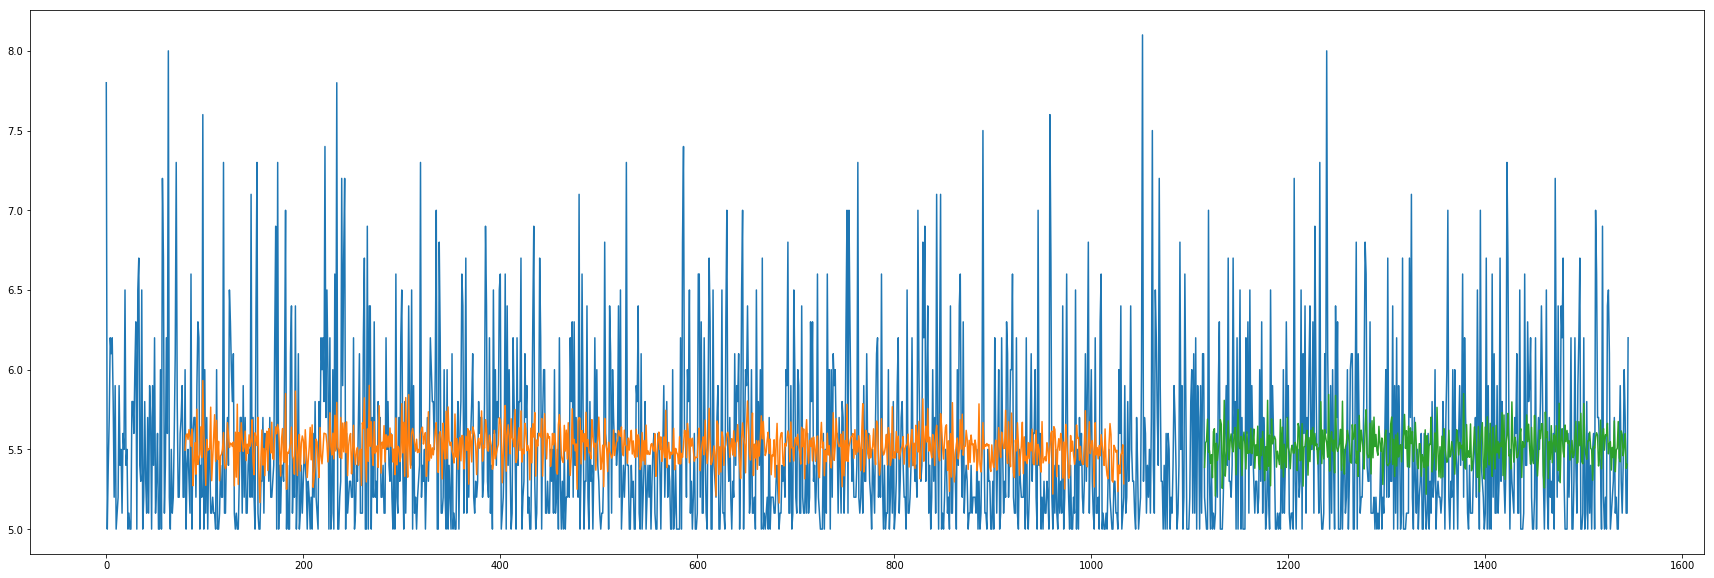

In [67]:
# 训练集的预测结果
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 测试集的预测结果
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 原始数据和预测结果
plt.figure(figsize=(30,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()